<a href="https://colab.research.google.com/github/sipocz/messer/blob/main/nitrogen_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Nitrogén predikció

In [2]:
import numpy as np
import pandas as pd

In [3]:
_PCVERSION_=False

if _PCVERSION_:
    basedir="C:/Users/sipocz/OneDrive/Dokumentumok/GitHub/nitrogen"
else:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    basedir="/content/drive/My Drive/001_AI/messer/nitrogen/"

Mounted at /content/drive


In [4]:
df=pd.read_csv(basedir+"all.csv")

In [5]:
df.head

<bound method NDFrame.head of                   timeStamp     LIN_V  LIN_P  PSA_M  PSA_P   PSA_Q
0       2019-11-21 09:58:15  32356.38   9.00  626.1    7.6  0.2749
1       2019-11-21 10:03:16  32346.85   9.00  663.1    7.7  0.2761
2       2019-11-21 10:03:21  32347.00   8.59  663.1    7.7  0.2761
3       2019-11-21 10:08:22  32350.00   8.61  548.9    7.7  0.2737
4       2019-11-21 10:13:21  32327.00   8.62  492.5    7.7  0.2694
...                     ...       ...    ...    ...    ...     ...
122418  2021-01-22 23:31:50  22143.00   8.41  593.7    7.8  0.2359
122419  2021-01-22 23:36:50  22145.00   8.42  566.3    7.8  0.2336
122420  2021-01-22 23:41:50  22142.00   8.42  510.0    7.8  0.2322
122421  2021-01-22 23:46:50  22141.00   8.43  450.1    7.8  0.2337
122422  2021-01-22 23:56:51  22139.00   8.43  554.1    7.8  0.2325

[122423 rows x 6 columns]>

In [6]:
df["timeStamp"]=pd.to_datetime(df["timeStamp"],format="%Y.%m.%d %H:%M:%S")   # konvertáljuk az időbélyeget


d=df[["timeStamp","PSA_M"]]
d.set_index("timeStamp",inplace=True)

In [7]:
d.head()

,PSA_M
timeStamp,
2019-11-21 09:58:15,626.1
2019-11-21 10:03:16,663.1
2019-11-21 10:03:21,663.1
2019-11-21 10:08:22,548.9
2019-11-21 10:13:21,492.5


In [8]:
agg_10m = d.groupby([pd.Grouper(freq='D')])
resample_mean =  d.resample("60min").agg({'PSA_M': 'mean'})  # újramintázzuk a jeleket, pl órás átlagokkal számoljunk
resample_max =  d.resample("60min").agg({'PSA_M': 'max'})    # újramintázzuk a jeleket, pl órás maxok
resample_min =  d.resample("60min").agg({'PSA_M': 'min'})    # újramintázzuk a jeleket, pl órás maxok
o_df=pd.DataFrame({"Max":resample_max.PSA_M,"Min":resample_min.PSA_M, "Mean":resample_mean.PSA_M})


In [9]:
#vizualizáció
o_df

,Max,Min,Mean
timeStamp,,,
2019-11-21 09:00:00,626.1,626.1,626.100000
2019-11-21 10:00:00,723.9,492.5,621.430769
2019-11-21 11:00:00,769.0,554.5,654.033333
2019-11-21 12:00:00,764.6,578.8,685.525000
2019-11-21 13:00:00,662.5,500.4,580.333333
...,...,...,...
2021-01-22 19:00:00,864.5,737.8,809.583333
2021-01-22 20:00:00,882.9,767.7,832.275000
2021-01-22 21:00:00,785.6,671.7,736.525000


In [10]:
import plotly.express as px


fig = px.line(o_df,x=o_df.index, y=o_df.Mean, title='Nitrogén tömegáram',range_y=(0,1500),)

fig.show()


In [11]:

import plotly.graph_objects as go


range1=0
range2=-1

fig = go.Figure([go.Scatter(x=o_df.index[range1:range2], y=o_df.Min,name="Min"),go.Scatter(x=o_df.index[range1:range2], y=o_df.Max, name="Max")])
fig.update_xaxes(
    dtick="M1",
    tickformat="'%d %B (%a)")
fig.update_yaxes(
    dtick="500")
fig.update_layout(  width=1900,  
                    title_text="Min Max Values",
                    )

fig.update_layout(yaxis_range=[0,1300])
fig.show()

In [12]:
o_df.notna()

,Max,Min,Mean
timeStamp,,,
2019-11-21 09:00:00,True,True,True
2019-11-21 10:00:00,True,True,True
2019-11-21 11:00:00,True,True,True
2019-11-21 12:00:00,True,True,True
2019-11-21 13:00:00,True,True,True
...,...,...,...
2021-01-22 19:00:00,True,True,True
2021-01-22 20:00:00,True,True,True
2021-01-22 21:00:00,True,True,True


In [13]:
print(f"{o_df['Min'].isnull().sum()} db NAN van a DF-ben" )
o_df.dropna(inplace=True)
print(f"{o_df['Min'].isnull().sum()} db NAN van a DF-ben" )


40 db NAN van a DF-ben
0 db NAN van a DF-ben


In [14]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' {} ellenőrzése'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print(dftest)
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
    print("--------------------------------------------")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [15]:
ADF_test(o_df.Min,'Minimum értékek')
ADF_test(o_df.Max,'Maximum értékek')
ADF_test(o_df.Mean,'Átlag értékek ')



 Minimum értékek ellenőrzése
(-4.582357689239793, 0.00013919459326058598, 6, 10240, {'1%': -3.430988763673373, '5%': -2.861822296275236, '10%': -2.5669202611637116}, 130543.60006367252)
Test statistic = -4.582
P-value = 0.000
Critical values :
	1%: -3.430988763673373 - The data is  stationary with 99% confidence
	5%: -2.861822296275236 - The data is  stationary with 95% confidence
	10%: -2.5669202611637116 - The data is  stationary with 90% confidence
--------------------------------------------
 Maximum értékek ellenőrzése
(-101.21758740456127, 0.0, 0, 10246, {'1%': -3.4309883895231814, '5%': -2.861822130940449, '10%': -2.566920173155941}, 795893.7975198245)
Test statistic = -101.218
P-value = 0.000
Critical values :
	1%: -3.4309883895231814 - The data is  stationary with 99% confidence
	5%: -2.861822130940449 - The data is  stationary with 95% confidence
	10%: -2.566920173155941 - The data is  stationary with 90% confidence
--------------------------------------------
 Átlag értékek 

In [16]:

start_pos = 2386 #@param {type:"slider", min:1000, max:5000, step:1}

weeknum =  9#@param {type:"integer"}

## 24 órás frekvencia?

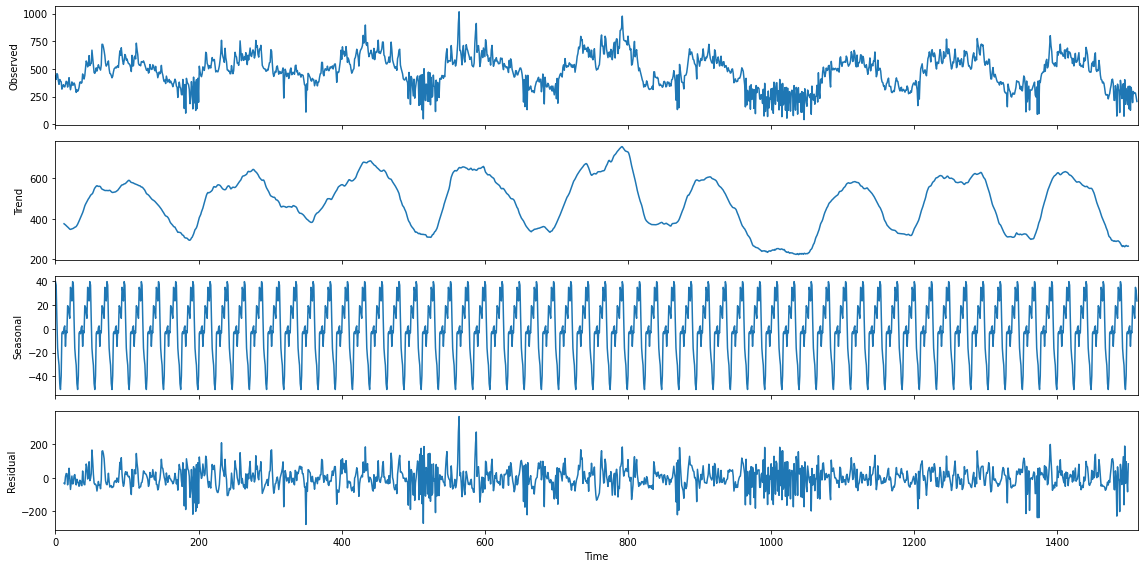

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure





plt.cla()
plt.close()

from statsmodels.tsa.seasonal import  seasonal_decompose

import matplotlib as mpl
with mpl.rc_context():
    mpl.rc("figure", figsize=(16,8))
    
    analysis = seasonal_decompose(o_df["Mean"][start_pos:start_pos+24*7*weeknum].values,model="additive", freq=24)
    #print(analysis.seasonal)
    analysis.plot()
    plt.show()

## Heti fekvencia ? 24*7 

In [18]:

start_pos = 3118 #@param {type:"slider", min:1000, max:5000, step:1}

weeknum =  12#@param {type:"integer"}

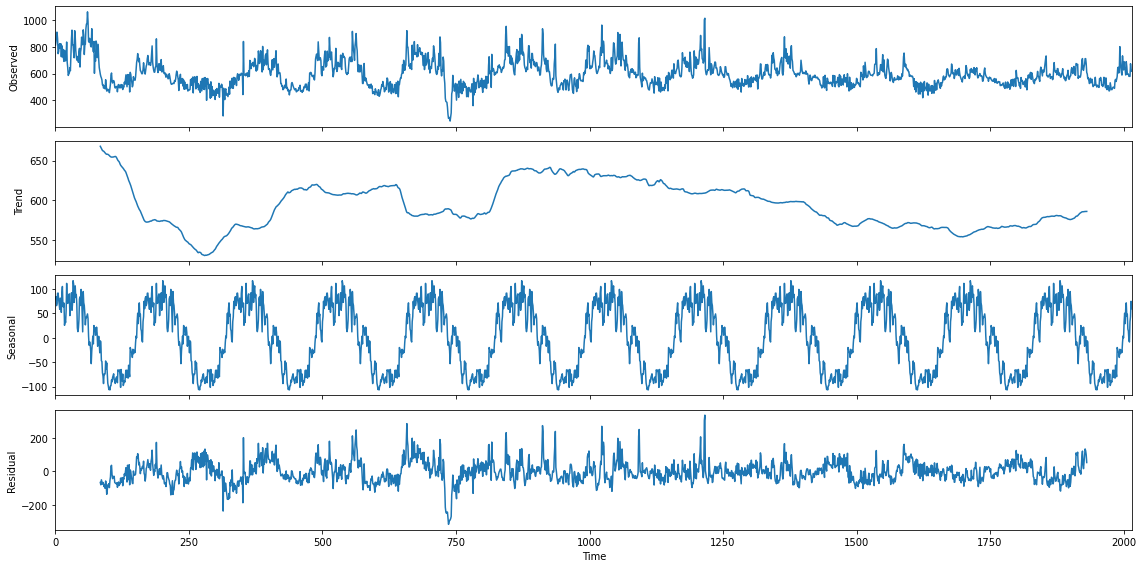

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure





plt.cla()
plt.close()

from statsmodels.tsa.seasonal import  seasonal_decompose

import matplotlib as mpl
with mpl.rc_context():
    mpl.rc("figure", figsize=(16,8))
    
    data1 = seasonal_decompose(o_df["Max"][start_pos:start_pos+24*7*weeknum].values,model="additive", freq=24*7)
    #print(analysis.seasonal)
    data1.plot()
    plt.show()

In [20]:

start_pos = 1702 #@param {type:"slider", min:1000, max:5000, step:1}

weeknum =  12#@param {type:"integer"}

In [21]:
import plotly.express as px
from plotly.subplots import make_subplots

data1 = seasonal_decompose(o_df["Max"][start_pos:start_pos+24*7*weeknum].values,model="additive", freq=24*7)
  

fig2 = make_subplots(rows=4, cols=1,shared_xaxes=True)
fig2.add_trace(
    go.Scatter(x=o_df.index[start_pos:start_pos+24*7*weeknum], y=data1.resid,name="Residual" ),

    row=1, col=1
)
fig2.add_trace(
    go.Scatter( x=o_df.index[start_pos:start_pos+24*7*weeknum], y=data1.trend,name="Trend"),

    row=2, col=1
)
fig2.add_trace(
    go.Scatter( x=o_df.index[start_pos:start_pos+24*7*weeknum], y=data1.seasonal,name="Seasonal"),

    row=3, col=1
)

fig2.add_trace(
    go.Scatter( x=o_df.index[start_pos:start_pos+24*7*weeknum], y=data1.observed,name="Observed"),

    row=4, col=1
)



fig2.update_layout(
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
  
)

fig2.show()


print(o_df.index[start_pos])

2020-01-31 08:00:00


In [22]:
!pip install lazypredict

In [143]:
from statsmodels.tsa.stattools import pacf, acf 
oa,ob=pacf(o_df.Max[:25000], nlags=200, alpha=0.1,)


In [144]:
import plotly.express as px

xl=list(range(len(oa)))
fig = px.line(oa,x=xl, y=oa, title='Nitrogén tömegáram',range_y=(-1,1),)

fig.add_trace(
    go.Scatter(x=xl,
               y=ob[:,1],
               )
    

)
fig.add_trace(
    go.Scatter(x=xl,
               y=ob[:,0],
               )
    

)


fig.show()




The null hypothesis of the test is that there is no serial correlation in the residuals. The Durbin-Watson test statistic is defined as:

∑t=2T((et−et−1)2)/∑t=1Te2t
The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

In [163]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
o1=durbin_watson(o_df.Min)
print(f"Durbin_Wattson elemzés eredménye: {o1}")
o2=adfuller(o_df.Mean)
print(f"ad_Fuller elemzés eredménye: {o2[1]},  nulla (0) ha nincs tendencia")

Durbin_Wattson elemzés eredménye: 0.02141501761290184
ad_Fuller elemzés eredménye: 0.0,  nulla (0) ha nincs tendencia


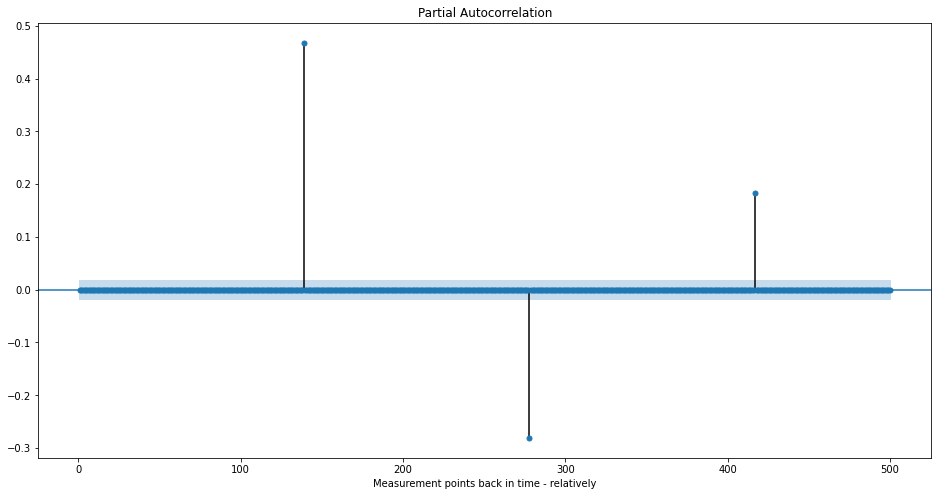

---


In [72]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, ax = plt.subplots(figsize=(16,8))


plot_pacf(o_df.Max[:], lags=500, zero=False, ax=ax)
plt.xlabel("Measurement points back in time - relatively")

plt.show()
print("---")

In [ ]:
statsmodels.graphics.tsa

In [30]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(o_df, test_size=0.1, shuffle=False)


In [38]:
sample=7*24
X_train=[]
y_train=[]
X_test=[]
y_test=[]

for t in range(len(list(train_data.Mean))-sample):
    a=list(train_data.Mean[t:t+sample])
    
    #print(a)
    X_train.append(a[0:sample-1])
    #print(a)
    y_train.append([a[-1]])

for t in range(len(list(test_data.Mean))-sample):
    a=list(test_data.Mean[t:t+sample])
    X_test.append(a[0:sample-1])
    y_test.append([a[-1]])


In [43]:
y_test[1]

[79.725]

In [39]:
from lazypredict.Supervised  import LazyRegressor
o=[]

prediction=[]
# Modell fittelése
lazyreg = LazyRegressor()

o=lazyreg.fit(pd.DataFrame(X_train),pd.DataFrame(X_test),pd.DataFrame(y_train),pd.DataFrame(y_test))

100%|██████████| 42/42 [04:39<00:00,  6.64s/it]


In [40]:
print(o)

(                                          Adjusted R-Squared  ...  Time Taken
Model                                                         ...            
HuberRegressor                                         -0.25  ...        0.19
NuSVR                                                  -0.44  ...       17.74
PassiveAggressiveRegressor                             -0.55  ...        0.24
SVR                                                    -0.57  ...       26.98
LinearSVR                                              -0.59  ...        0.14
MLPRegressor                                           -4.78  ...       22.57
KNeighborsRegressor                                    -7.00  ...        2.31
SGDRegressor                                -109424339821.73  ...        0.26
RANSACRegressor                        -18645284357738408.00  ...        1.94
RandomForestRegressor             -6453853179322447167488.00  ...       33.36
BaggingRegressor                  -9303122502809371541504.00  .

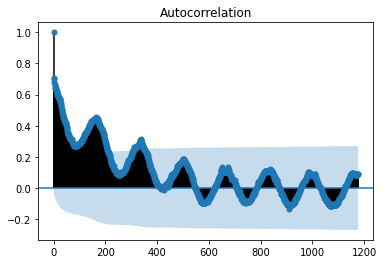

timeStamp
2019-11-21 09:00:00   626.10
2019-11-21 10:00:00   723.90
2019-11-21 11:00:00   769.00
2019-11-21 12:00:00   764.60
2019-11-21 13:00:00   662.50
                       ...  
2020-06-17 15:00:00   637.00
2020-06-17 16:00:00   611.70
2020-06-17 17:00:00   586.50
2020-06-17 18:00:00   603.10
2020-06-17 19:00:00   587.70
Name: Max, Length: 5000, dtype: float64

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
dta = o_df.Max[:5000]
dta.index = o_df.index[:5000]


sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=24*7*7)
plt.show()
